# Learning objectives
- Understand and apply Experimental Design (ED) techniques, including:
    - Univariate feature selection based on $\chi^2$-test and Mutual Information
    - Alternative evaluation methods to holdout: $k-$-fold Cross Validation and Bootstrapping
    - Alternative performance metrics to accuracy for classification: recall, precision, F1
- A demonstration of the imbalanced classification problem and ED solutions to it

# Univariate feature selection
## <u>Concept: Feature filtering based on $\chi^2$-Test for classification</u>

Consider the following binary class problem:

| HighSales | HasSequel | IsPopular |
|-------------------|--------------------|------------------|
| T                 | F                  | +                |
| T                 | T                  | +                |
| T                 | T                  | +                |
| T                 | F                  | -                |
| T                 | T                  | +                |
| F                 | F                  | -                |
| F                 | F                  | -                |
| F                 | F                  | -                |
| T                 | T                  | -                |
| F                 | F                  | -                |

Here, we wish to predict if `IsPopular` (the _class label_) given `HighSales` (sold many tickets) and `HasSequel` (has a sequel). For the following questions, we want to select the feature that best predicts whether or not the movie is Popular using the $\chi^2$-Test.

- Hypothesis testing is one way of statistically testing the significance of a feature or value.
- In this example, we are calculating the $\chi^2$ values of our feature `"HighSales"` w.r.t (with respect to) our class label `"IsPopular"`.

To create a hypothesis test, we propose the following:
1. Null Hypothesis: The feature is is not significant. In other words, the feature is useless and doesn't provide anything useful.
2. Alternative Hypothesis: The feature is significant and provides useful insight statistically.

To find out what hypothesis holds, we need to compute the `p-value`.

**So what's the p-value?**
- The `p-value` is the *probability* of obtaining results that are *at least as extreme* (i.e outliers) as the results observed.
- These observations are under the assumption that the Null hypothesis is correct (the feature is useless).
- However, if the `p-value` is small, then it means that our *observed extreme results* are very unlikely under the Null hypothesis. 
- Therefore, given some significance threshold $\alpha$ (usually at 0.05), we **reject the Null hypothesis** i.f.f (if and only if) the `p-value` < $\alpha$.

<blockquote style="padding: 10px; background-color: #FFD392;">

   
## Individual Exercise 1 (By Hand)
Do the following questions by hand (without code):
1. Compute the Observed and Expected contingency tables for `HighSales`. 
2. Calculate the $\chi^2$(`HighSales`, `IsPopular`) value. To do so, you will also need to find out the \textit{degrees of freedom (DoF)}.
3. Conclude whether `HighSales` is independent of `IsPopular` at the $\alpha=0.05$ significance level (p-value less than $\alpha=0.05$). Use the table below for your calculations.
    
| DoF | $\alpha$=0.05 | $\alpha$=0.01 | $\alpha$=0.001 |
|-----|---------------|---------------|----------------|
| 1   | 3.84          | 6.64          | 10.83          |
| 2   | 5.99          | 9.21          | 13.82          |
| 3   | 7.82          | 11.35         | 16.27          |
| 4   | 9.49          | 13.28         | 18.47          |
| 5   | 11.07         | 15.09         | 20.52          |
| 6   | 12.59         | 16.81         | 22.46          |

4. Repeat the process for `HasSequel` and decide which feature could be best used for predicting `IsPopular`.

Now that we have worked it out by hand, let's implement the same approach using Python code. If you're planning to conduct feature selection using the $\chi^2$-Test for your group project, you should follow through with this code.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import scipy.stats as stats

from scipy.stats import chi2_contingency

In [2]:
# this is the same table of data from above 
data = pd.DataFrame([[1,0,1], [1,1,1], [1,1,1], [1,0,0], [1,1,1], [0,0,0], [0,0,0], [0,0,0], [1,1,0], [0,0,0]], 
                    columns=['HighSales','HasSequel','IsPopular'])

data

,HighSales,HasSequel,IsPopular
0,1,0,1
1,1,1,1
2,1,1,1
3,1,0,0
4,1,1,1
5,0,0,0
6,0,0,0
7,0,0,0
8,1,1,0
9,0,0,0


In [3]:
# set our alpha significance level
ALPHA = 0.05

# get our features and class label
features = data[['HighSales','HasSequel']]
class_label = data['IsPopular']

Now that we have worked it out by hand, let's implement the same approach using Python code. If you're planning to conduct feature selection using the $\chi^2$-Test for your group project, you should follow through with this code.

In [4]:
cont_table = pd.crosstab(class_label, features['HighSales'])
cont_table

HighSales,0,1
IsPopular,,
0,4,2
1,0,4


Now, we can use `stats.chi2_contigency(contingency_table, correction=False)` to get the $\chi^2$-Test Statistic, `p-value`, the Degrees-of-Freedom, and the Expected values. 

The `correction=False` flag is to disable Yates' correction for continuity when there is 1 degree-of-freedom (out of scope for this subject).

In [5]:
chi2_val, p, dof, expected_values = stats.chi2_contingency(cont_table.values, correction=False)
print(chi2_val)
print(p)
print(dof)

# this is the expected values for the Chi^2 test
print(expected_values)

4.444444444444445
0.03501498101966245
1
[[2.4 3.6]
 [1.6 2.4]]


From above, we can see that our `p-value` is $\approx0.035$ which is less than $\alpha=0.05$. Therefore, we would **reject the Null Hypothesis**.

To do both `HighSales` and `HasSequel` together, we can use a `for` loop as shown below:

In [6]:
filtered_features = []

for feature in ('HighSales','HasSequel'):
    cont_table = pd.crosstab(class_label, features[feature])
    chi2_val, p, dof, expected = stats.chi2_contingency(cont_table.values, correction=False)
    
    print(f'Chi2 value for feature "{feature}": {chi2_val:.4f}')
    
    if(p < ALPHA): 
        filtered_features.append(feature)
        print(f'Reject the Null Hypothesis for feature "{feature}", p-value {p:.4f}\n')
    else:
        print(f'Fail to reject the Null Hypothesis for feature "{feature}", p-value {p:.4f}\n')
        
print('Feature set after filtering with Chi-square test:', filtered_features)

Chi2 value for feature "HighSales": 4.4444
Reject the Null Hypothesis for feature "HighSales", p-value 0.0350

Chi2 value for feature "HasSequel": 3.4028
Fail to reject the Null Hypothesis for feature "HasSequel", p-value 0.0651

Feature set after filtering with Chi-square test: ['HighSales']


## <u>Concept: Feature filtering based on Mutual Information for classification</u>

In a similar fashion, we can use Mutual Information (MI) as the metric to evaluate how well-correlated the feature is with the class if the feature is a discrete variable. We will use the in-built `mutual_info_classif` function from `sklearn.feature_selection` module to calculate this score for each feature, and will include / exclude that feature depending on how high the MI is. Note that `sklearn`'s implementation of MI uses the natural logarithm instead of base 2.

In [7]:
from sklearn.feature_selection import mutual_info_classif

filtered_features = []

# Similar to ALPHA in Chi-square testing, we select a threshold level for accepting / rejecting features
THRESHOLD = 0.2

mi_arr = mutual_info_classif(X=features, y=class_label, discrete_features=True)

for feature, mi in zip(features.columns, mi_arr):
    print(f'MI value for feature "{feature}": {mi:.4f}')
    
    if(mi >= THRESHOLD): 
        filtered_features.append(feature)
        
print('\nFeature set after filtering with MI:', filtered_features)

MI value for feature "HighSales": 0.2911
MI value for feature "HasSequel": 0.1777

Feature set after filtering with MI: ['HighSales']


# Evaluation method

## <u> Concept: $k$-fold Cross Validation (CV)</u>
- The approach randomly divides the dataset into $k$ approximately equal "folds" or "partitions".
- Each of these "folds" is then used as an evaluation set in $k$ different iterations. 
- That is, each iteration of $k$-fold CV will have different "folds" taking turns at being the evaluation set.

For example, if we had $k=3$, then:
- The first iteration involves having "folds" 1 & 2 for train, with 3 for evaluation.
- In the next iteration, we might have "folds" 1 & 3 for train, with 2 for evaluation.
- (and so on...)

**Discussion Question:**
- Why do we need to do $k$-fold CV when we have techniques such as holdout (train-test split)?
- What are the pros and cons of $k$-fold CV

**Answer:**
- The common train-test split is unreliable due to some factors such as a fixed random seed. You may end up with biased labels or data points in specific splits which can lead to poor model fitting or over fitting.
- $k$-fold CV overcomes this by using every partition for training and testing, then, taking the average performance for a more reliable accuracy.
- However, $k$-fold CV is much slower in run-time as you need to re-train and re-test the model several times.

### Data preparation

In [8]:
data = pd.read_csv('sentiment.csv')
data.head()

,review,sentiment
0,"""Avengers: Endgame"" is about memories, nostalg...",0
1,"""Avengers: Endgame"" is an excellent commercial...",1
2,"""Avengers: Endgame"" is nothing short of a spec...",1
3,"""Avengers: Endgame"" is probably one of Marvel'...",1
4,(RottenTomatoes)- They delete my reviews frequ...,-1


In [9]:
from sklearn.feature_extraction.text import CountVectorizer
import scipy

# create our X and y features
X = data['review']
y = data['sentiment']

# vectorize our X matrix (bag-of-words format)
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(X)

print(X.shape)
X

(658, 6456)


<658x6456 sparse matrix of type '<class 'numpy.int64'>'
	with 31366 stored elements in Compressed Sparse Row format>

It's worth noting that we have a _sparse matrix_. What does this mean?

If you want to "view" it and convert it back to a _dense_ matrix, see the following example.

In [10]:
X = scipy.sparse.csr_matrix.todense(X)
X

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### 5-fold cross validation with 5-NN classifier 

In [11]:
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score

In [12]:
# set k=5 value for k-fold CV
k = 5

kf_CV = KFold(n_splits=k, shuffle=True, random_state=42)
results = []

The result is a generator object of `k` tuples in the form of (list of train indices, list of test indices). 

So, the idea is that we will grab the indices generated by the `kfold` and then subset `X` and `y` to get `X_train`, `X_test`, `y_train`, `y_test`. 

Note that this has to be done manually, as opposed to the normal use of `train_test_split`.

In [13]:
for train_idx, test_idx in kf_CV.split(X):
    # train-test split
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Preprocessing
    # 1. Standardise the data
    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
    # Training
    knn = KNN(n_neighbors=5)
    knn.fit(X_train, y_train)    
    
    # Predictions
    y_pred = knn.predict(X_test)
    results.append(accuracy_score(y_test, y_pred))

C:\Users\Diamo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Diamo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Diamo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Diamo\Anaconda3\lib\site-

In [14]:
print(f"Average Accuracy: {np.mean(results)}")

Average Accuracy: 0.4954661114966458


<blockquote style="padding: 10px; background-color: #ebf5fb;">

## Class Discussion Questions
1. What happens when we have diferent values of $k$ or change the random seed?
2. What might be an optimal value of $k$ for this dataset?
3. Is a large $k$ always good?

**Answer:**  
- _Generally, larger values of $k$ is useful for getting more accurate results as we have more training data._
- _For example, if $k$ were 2 or 3, we would end up with a 50/50 or 66/34 split which might be ineffective._
- _However, if we choose $k$ to be too large, it will take far longer to process and retrain the model._
- _To further improve this, there are techniques such as stratified $k$-fold CV or repeated $k$-fold CV._

# Performance metrics for imbalanced classification

Imbalanced classification is an issue in ML classification when there is an unequal distribution of classes in the training dataset. This results in models that have poor predictive performance, specifically for the minority class.

So far, we have only used accuracy as the sole metric for evaluating the performance of a classifer. In the following example with a heavily imbalanced subset of the `sentiment` dataset, we will see that it is a misleading indicator of performance on imbalanced problems. Furthermore, we will discuss some alternative metrics, namely recall, precision and F1 score.

-1    360
 1     40
Name: sentiment, dtype: int64


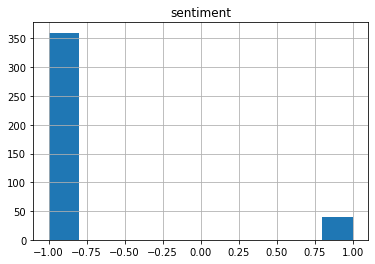

In [15]:
import pandas as pd
import numpy as np
import scipy.sparse
from sklearn.feature_extraction.text import CountVectorizer

# Load the imbalanced dataset
imbalance = pd.read_csv('sentiment_imbalance.csv')

# Check the class label to see that it is imbalanced classification (N=400)
print(imbalance['sentiment'].value_counts())
imbalance.hist('sentiment')
plt.show()

In [16]:
# Get X, y
X_imb = imbalance['review']
y_imb = np.array(imbalance['sentiment'])

# CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X_imb = vectorizer.fit_transform(X_imb) # Encoding text into BoW format and treat them as nominal features
print('Number of rows & columns:', X_imb.shape)
X_imb = scipy.sparse.csr_matrix.todense(X_imb)

Number of rows & columns: (400, 4034)


In [17]:
# Train the 5-NN model on a single holdout

from sklearn.model_selection import train_test_split
from sklearn import neighbors

X_imb_train, X_imb_test, y_imb_train, y_imb_test = train_test_split(X_imb, y_imb, train_size=0.8, random_state=42)

print('Distribution of test classes:')
pd.Series(y_imb_test).value_counts()

Distribution of test classes:


-1    70
 1    10
dtype: int64

In [18]:
knn = KNN(n_neighbors=5)
knn.fit(X_imb_train, y_imb_train)
y_imb_pred=knn.predict(X_imb_test)

print('Accuracy:', accuracy_score(y_imb_test, y_imb_pred))

Accuracy: 0.875


C:\Users\Diamo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Diamo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


Remember that we have 70 test instances with `-1` class, and only 10 with `1` class (minority class). Just looking at the accuracy score of `0.875`, it looks like the model correctly predicted 70 out of 80 testing instances, which is great. But let's take a look at the confusion matrix to drill down its performance for each class:

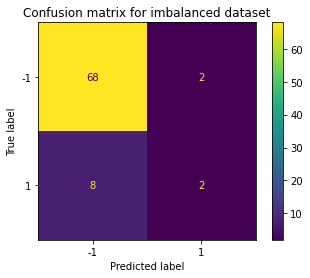

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_imb_test, y_imb_pred, labels=knn.classes_)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=knn.classes_).plot()
plt.title('Confusion matrix for imbalanced dataset')
plt.show()

As you can see, even though the model correctly predicted 70 instances, it only correctly predicted 2/10 minority class instances. In fact, the model only predicted 4 instances to be class `1`, which means that it is not a great model at all! Let's calculate some alternative metrics to evaluate this model using the `sklearn.metrics` module:

In [20]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print('Recall:', recall_score(y_imb_test, y_imb_pred))
print('Precision:', precision_score(y_imb_test, y_imb_pred))
print('F1:', f1_score(y_imb_test, y_imb_pred))

Recall: 0.2
Precision: 0.5
F1: 0.28571428571428575


<blockquote style="padding: 10px; background-color: #ebf5fb;">

## Class Discussion Questions
1. Using the values from the confusion matrix, show all calculations to confirm the `sklearn` recall, precision, and f1 scores (refer to the formulas in the lecture slides)
2. When do you prefer recall over precision? When do you prefer precision over recall?
3. In the current use case (evaluating the performance of a sentiment predictor), which metric is the most appropriate and why?

## <u> Concept: Bootstrapping</u>

Similar to how we can combine k-fold CV to get an average accuracy score, we can use k-fold CV with any of these alternative metrics. And of course, you can use multiple metrics to evaluate a single model to identify its strengths and weaknesses in a more holistic picture.

For imbalanced datasets, however, we may also use **bootstrapping** instead of k-fold CV to get a range of performance scores. In this model evaluation method, you draw multiple training sets by random sampling from the training data wit replacement; these samples are called bootstrap samples. You can use `resample()` method in scikit-learn 
https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html

You train the model multiple times with the bootstrap samples.
You obtain the performance scores from the corresponding test sets.
The test set, for a bootstrap sample, contain observations not in (unseen) the bootstrap sample.

This set of scores give you a range of performance scores, from which you can calculate mean, sd and confidence interval of the performance.
They provide a distribution for the perfomance of the classification model.


Unlike k-fold, bootstrapping doesn't have an off-the-shelf function in `scikit-learn`, so we have to implement them with the `resample()` utility function. In the following section, we will show how you can use this function to generate repeated samples.

In [21]:
# scikit-learn bootstrap
from sklearn.utils import resample

n = X_imb.shape[0]
# data index
dataidx = range(n)

# number of bootstrap samples
k = 10

# a list to store the bootstrap sample indices
bs = []

# Perform bootstrapping k times
for j in range(k):
    
    # prepare bootstrap sample
    boot_index = resample(range(n), replace=True, n_samples=n, random_state=j)
    # out of bag observations
    oob_index = [x for x in range(n) if x not in boot_index]
    bs.append((boot_index, oob_index))
    
# Note that the size of oob_index list is different for each bootstrapping,
# but the size of boot_index list is always the same (n)
print(bs[0])

([172, 47, 117, 192, 323, 251, 195, 359, 9, 211, 277, 242, 292, 87, 70, 88, 396, 314, 193, 39, 87, 174, 88, 337, 165, 25, 333, 72, 265, 115, 243, 197, 335, 338, 99, 177, 243, 285, 147, 147, 398, 288, 265, 185, 127, 32, 31, 202, 244, 151, 163, 370, 183, 28, 290, 128, 128, 53, 389, 38, 244, 273, 335, 388, 105, 42, 31, 376, 257, 321, 57, 291, 358, 119, 267, 82, 91, 384, 398, 99, 53, 396, 121, 84, 203, 324, 262, 47, 127, 131, 356, 180, 334, 143, 148, 227, 279, 207, 397, 373, 341, 48, 305, 69, 169, 163, 95, 197, 94, 256, 369, 178, 292, 304, 349, 387, 98, 42, 368, 201, 383, 0, 394, 370, 43, 383, 23, 187, 130, 377, 98, 62, 222, 123, 82, 227, 148, 209, 50, 270, 41, 58, 193, 36, 266, 86, 43, 360, 11, 258, 307, 80, 32, 182, 128, 294, 275, 174, 42, 371, 184, 77, 286, 280, 125, 258, 3, 94, 226, 363, 269, 368, 296, 328, 19, 95, 328, 248, 180, 323, 317, 270, 352, 260, 237, 139, 86, 377, 109, 331, 184, 16, 152, 149, 110, 25, 377, 374, 117, 83, 161, 360, 228, 251, 121, 326, 287, 13, 327, 184, 152, 79,

In practice, you don't need to generate the indices separately, but you can incorporate the resampling inside the for loop

In [22]:
# Storing the metrics for each dataset
accuracies = []
precisions = []
recalls = []
f1s = []

# Loop through each dataset, split data based on bootstrapping indices + fit model + evaluate
for k in range(10):
    # prepare bootstrap sample
    boot_index = resample(range(n), replace=True, n_samples=n, random_state=k)
    # out of bag observations
    oob_index = [x for x in range(n) if x not in boot_index]
    # Split datasets
    X_imb_train = X_imb[boot_index,:]
    X_imb_test = X_imb[oob_index,:]
    y_imb_train = y_imb[boot_index]
    y_imb_test = y_imb[oob_index]
    
    # Train
    knn = KNN(n_neighbors=5)
    knn.fit(X_imb_train, y_imb_train)
    
    # Predict
    y_imb_pred=knn.predict(X_imb_test)
    
    # Evaluate
    accuracies.append(accuracy_score(y_imb_test, y_imb_pred))
    recalls.append(recall_score(y_imb_test, y_imb_pred))
    precisions.append(precision_score(y_imb_test, y_imb_pred))
    f1s.append(f1_score(y_imb_test, y_imb_pred))

C:\Users\Diamo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Diamo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Diamo\Anaconda3\lib\site-packages\sklearn\utils\validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
C:\Users\Diamo\Anaconda3\lib\site-

In [23]:
print("Accuracy from each bootstrap sample:", accuracies)
#Display average of accuracy scores
avg_acc_score = np.mean(accuracies)
print("Mean accuracy from all bootstrap samples:", avg_acc_score)

Accuracy from each bootstrap sample: [0.8843537414965986, 0.8723404255319149, 0.8785714285714286, 0.8581081081081081, 0.8657718120805369, 0.8308823529411765, 0.7569444444444444, 0.9057971014492754, 0.7702702702702703, 0.7516339869281046]
Mean accuracy from all bootstrap samples: 0.9305192968690954


In [24]:
print("Precision from each bootstrap sample:", precisions)
#Display average of precision scores
avg_precision_score = np.mean(precisions)
print("Mean precision from all bootstrap samples:", avg_precision_score)

Precision from each bootstrap sample: [0.4, 0.3333333333333333, 0.5, 0.14285714285714285, 0.2222222222222222, 0.1, 0.2, 0.2, 0.1935483870967742, 0.08333333333333333]
Mean precision from all bootstrap samples: 0.2639216020936451


In [25]:
print("Recall from each bootstrap sample:", recalls)
#Display average of recall scores
avg_recall_score = np.mean(recalls)
print("Mean recall from all bootstrap samples:", avg_recall_score)

Recall from each bootstrap sample: [0.125, 0.058823529411764705, 0.4117647058823529, 0.18181818181818182, 0.4, 0.2857142857142857, 0.5, 0.1, 0.4, 0.1111111111111111]
Mean recall from all bootstrap samples: 0.2860257571041884
